### Negotiation Deadlock

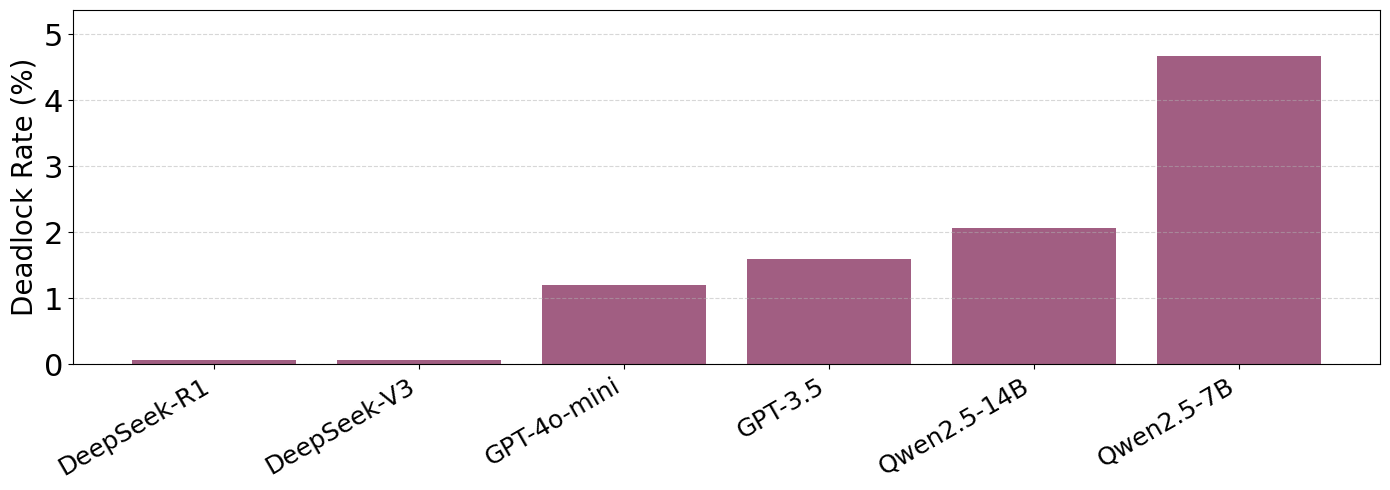

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
def count_max_turn_deadlocks():
    # Base directory for max_turn data
    base_dir = "../error_data/max_turn"
    
    # The models we need to track
    models = ["deepseek-reasoner", "deepseek-chat", "gpt-4o-mini", "gpt-3.5-turbo", 
              "qwen2.5-7b-instruct", "qwen2.5-14b-instruct"]
    
    # Initialize counter for each model's deadlocks as buyer
    deadlock_count = {model: 0 for model in models}
    
    # Loop through all seller directories
    for seller_folder in os.listdir(base_dir):
        seller_path = os.path.join(base_dir, seller_folder)
        if not os.path.isdir(seller_path):
            continue
            
        # Extract seller model name
        seller_model = seller_folder.replace("seller_", "")
        
        # Loop through all buyer directories
        for buyer_model in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_model)
            if not os.path.isdir(buyer_path):
                continue
                
            # If this buyer is in our models list, count all JSON files under it
            if buyer_model in models:
                file_count = 0
                
                # Walk through all subdirectories to count JSON files
                for root, dirs, files in os.walk(buyer_path):
                    file_count += sum(1 for f in files if f.endswith('.json'))
                
                deadlock_count[buyer_model] += file_count
    
    # Calculate the deadlock rate for each model
    total_expected = 5 * 50 * 6  # 5 budgets * 50 products * 6 sellers
    deadlock_rate = {}
    for model in models:
        # Ensure no division by zero
        deadlock_rate[model] = deadlock_count[model] / total_expected if total_expected > 0 else 0
    
    # Sort models by deadlock rate in descending order
    sorted_models = sorted(deadlock_rate.items(), key=lambda x: x[1], reverse=False)
    
    # Rename models for display
    display_names = {
        "deepseek-reasoner": "DeepSeek-R1",
        "deepseek-chat": "DeepSeek-V3",
        "gpt-4o-mini": "GPT-4o-mini",
        "gpt-3.5-turbo": "GPT-3.5",
        "qwen2.5-7b-instruct": "Qwen2.5-7B",
        "qwen2.5-14b-instruct": "Qwen2.5-14B"
    }
    
    # Prepare data for plotting
    models_display = [display_names.get(model, model) for model, _ in sorted_models]
    rates = [rate * 100 for _, rate in sorted_models]  # Convert to percentage
    
    # Create the bar plot
    plt.figure(figsize=(14, 5))
    colors = sns.color_palette("ch:s=-.2,r=.6", n_colors=10)
    bars = plt.bar(models_display, rates, color=colors[5])
    

    plt.ylabel('Deadlock Rate (%)', fontsize=20)
    plt.xticks(rotation=30, ha='right', fontsize=18)
    plt.ylim(0, max(rates) * 1.15)  # Add 15% margin at the top
    plt.yticks(fontsize=22)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
   
    # Save the figure
    output_dir = "../figures"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "deadlock_rate.svg"), dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    # Return the data for reference
    return sorted_models, deadlock_count

if __name__ == "__main__":
    count_max_turn_deadlocks()

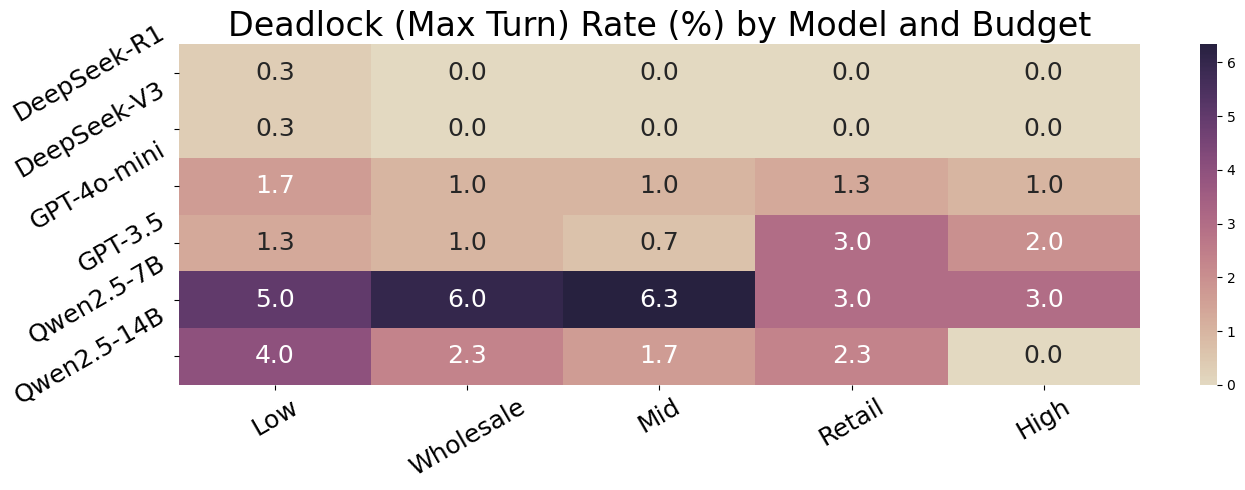

In [2]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def count_deadlock_rate_by_budget_heatmap():
    base_dir = "../error_data/max_turn"
    models = ["deepseek-reasoner", "deepseek-chat", "gpt-4o-mini", "gpt-3.5-turbo", 
              "qwen2.5-7b-instruct", "qwen2.5-14b-instruct"]
    budgets = ["low", "wholesale", "mid", "retail", "high"]

    deadlock_count = {model: {budget: 0 for budget in budgets} for model in models}

    for seller_folder in os.listdir(base_dir):
        seller_path = os.path.join(base_dir, seller_folder)
        if not os.path.isdir(seller_path):
            continue
        for buyer_model in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_model)
            if not os.path.isdir(buyer_path):
                continue
            if buyer_model in models:
                for root, dirs, files in os.walk(buyer_path):
                    for file in files:
                        if file.endswith('.json'):
                            for budget in budgets:
                                if f"budget_{budget}" in root:
                                    deadlock_count[buyer_model][budget] += 1
                                    break

    num_products = 50
    num_sellers = 6
    total_expected = num_products * num_sellers  # 300


    deadlock_rate = np.zeros((len(models), len(budgets)))
    for i, model in enumerate(models):
        for j, budget in enumerate(budgets):
            deadlock_rate[i, j] = deadlock_count[model][budget] / total_expected * 100  


    display_names = {
        "deepseek-reasoner": "DeepSeek-R1",
        "deepseek-chat": "DeepSeek-V3",
        "gpt-4o-mini": "GPT-4o-mini",
        "gpt-3.5-turbo": "GPT-3.5",
        "qwen2.5-7b-instruct": "Qwen2.5-7B",
        "qwen2.5-14b-instruct": "Qwen2.5-14B"
    }
    model_labels = [display_names[m] for m in models]
    budget_labels = ["Low", "Wholesale", "Mid", "Retail", "High"]

    plt.figure(figsize=(14, 5))
    ax = sns.heatmap(deadlock_rate, annot=True, fmt=".1f", cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True), 
                     xticklabels=budget_labels, yticklabels=model_labels, annot_kws={"fontsize": 18})

    plt.xticks(fontsize=18, rotation=30)
    plt.yticks(fontsize=18, rotation=30)
    plt.title("Deadlock (Max Turn) Rate (%) by Model and Budget", fontsize=24)
    plt.tight_layout()

    output_dir = "../figures"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "deadlock_rate_by_budget_heatmap.svg"), dpi=300, bbox_inches='tight')
    plt.show()

    return deadlock_rate

if __name__ == "__main__":
    count_deadlock_rate_by_budget_heatmap()

### Overpayment

In [5]:
import os
import json
from collections import defaultdict

def print_overpayment_stats():
    # Directories for analysis
    overpayment_dir = "../error_data/higher_than_retail"
    results_dir = "../results"
    
    # Data structures to track statistics
    buyer_stats = defaultdict(lambda: {"total_accepted": 0, "overpayment": 0})
    
    # First, count total accepted negotiations per buyer model from results directory
    print("Analyzing total accepted negotiations...")
    
    # Process the results directory to get total accepted negotiations
    for seller_dir in os.listdir(results_dir):
        seller_path = os.path.join(results_dir, seller_dir)
        if not os.path.isdir(seller_path):
            continue
            
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            if not os.path.isdir(buyer_path):
                continue
                
            # Traverse through product and budget folders to reach json files
            for root, dirs, files in os.walk(buyer_path):
                for file in files:
                    if file.endswith('.json'):
                        file_path = os.path.join(root, file)
                        
                        try:
                            with open(file_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            seller_model = seller_dir.replace("seller_", "")
                            buyer_model = buyer_dir
                            
                            if "models" in data and "buyer" in data["models"]:
                                buyer_model = data["models"]["buyer"]
                            
                            if data.get("negotiation_result") == "accepted":
                                buyer_stats[buyer_model]["total_accepted"] += 1
                        
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    # Process the overpayment directory
    print("Analyzing overpayments...")
    for seller_dir in os.listdir(overpayment_dir):
        seller_path = os.path.join(overpayment_dir, seller_dir)
        if not os.path.isdir(seller_path):
            continue
            
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            if not os.path.isdir(buyer_path):
                continue
                
            for root, dirs, files in os.walk(buyer_path):
                for file in files:
                    if file.endswith('.json'):
                        file_path = os.path.join(root, file)
                        
                        try:
                            with open(file_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            seller_model = seller_dir.replace("seller_", "")
                            buyer_model = buyer_dir
                            
                            if "models" in data and "buyer" in data["models"]:
                                buyer_model = data["models"]["buyer"]
                            
                            if data.get("negotiation_result") == "accepted" and data.get("overpayment") == True:
                                buyer_stats[buyer_model]["overpayment"] += 1
                        
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    # Calculate rates and prepare for sorting
    model_rates = []
    for model, stats in buyer_stats.items():
        if stats["total_accepted"] > 0:
            rate = stats["overpayment"] / stats["total_accepted"]
            model_rates.append((model, rate, stats["overpayment"], stats["total_accepted"]))
    
    # Sort by overpayment rate
    sorted_models = sorted(model_rates, key=lambda x: x[1], reverse=False)
    
    # Print results
    print("\nOverpayment Statistics:")
    print("-" * 65)
    print(f"{'Model':<30} {'Rate':<10} {'Overpayments':<15} {'Total Accepted':<15}")
    print("-" * 65)
    
    for model, rate, overpayments, total in sorted_models:
        print(f"{model:<30} {rate:.4f} {overpayments:<15} {total:<15}")
    
    print("-" * 65)
    
    # Calculate and print overall stats
    total_accepted = sum(stats["total_accepted"] for stats in buyer_stats.values())
    total_overpayment = sum(stats["overpayment"] for stats in buyer_stats.values())
    overall_rate = total_overpayment / total_accepted if total_accepted > 0 else 0
    print(f"Overall Rate: {overall_rate:.4f}")
    print(f"Total Overpayments: {total_overpayment}")
    print(f"Total Accepted Negotiations: {total_accepted}")

if __name__ == "__main__":
    print_overpayment_stats()

Analyzing total accepted negotiations...
Analyzing overpayments...

Overpayment Statistics:
-----------------------------------------------------------------
Model                          Rate       Overpayments    Total Accepted 
-----------------------------------------------------------------
deepseek-chat                  0.0000 0               657            
deepseek-reasoner              0.0000 0               825            
gpt-3.5-turbo                  0.0115 9               784            
qwen2.5-14b-instruct           0.0121 9               743            
gpt-4o-mini                    0.0146 6               412            
qwen2.5-7b-instruct            0.0218 16              735            
-----------------------------------------------------------------
Overall Rate: 0.0096
Total Overpayments: 40
Total Accepted Negotiations: 4156


Analyzing total accepted negotiations...
Analyzing overpayments...


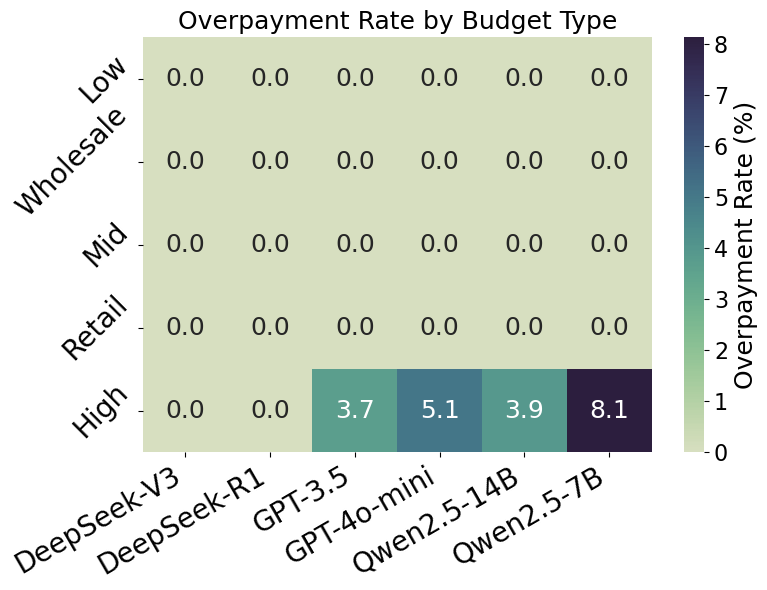

In [5]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def calculate_overpayment_heatmap():
    # Directories for analysis
    overpayment_dir = "../error_data/higher_than_retail"
    results_dir = "../results"
    
    # Data structures to track statistics
    # Format: buyer_budget_stats[buyer_model][budget_type] = {"total_accepted": 0, "overpayment": 0}
    buyer_budget_stats = defaultdict(lambda: defaultdict(lambda: {"total_accepted": 0, "overpayment": 0}))
    
    # Budget types in specified order
    budget_types = ['low', 'wholesale', 'mid', 'retail', 'high']
    
    # First, count total accepted negotiations per buyer model and budget type
    print("Analyzing total accepted negotiations...")
    
    # Process the results directory to get total accepted negotiations
    for seller_dir in os.listdir(results_dir):
        seller_path = os.path.join(results_dir, seller_dir)
        if not os.path.isdir(seller_path):
            continue
            
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            if not os.path.isdir(buyer_path):
                continue
                
            # Traverse through product and budget folders to reach json files
            for root, dirs, files in os.walk(buyer_path):
                for file in files:
                    if file.endswith('.json'):
                        file_path = os.path.join(root, file)
                        
                        try:
                            # Read JSON data
                            with open(file_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            # Get buyer model from directory structure or JSON
                            buyer_model = buyer_dir
                            if "models" in data and "buyer" in data["models"]:
                                buyer_model = data["models"]["buyer"]
                            
                            # Get budget type from directory path
                            budget_type = None
                            for budget in budget_types:
                                if f"budget_{budget}" in file_path:
                                    budget_type = budget
                                    break
                            
                            # Skip if we couldn't determine the buyer model or budget type
                            if not buyer_model or not budget_type:
                                continue
                            
                            # Count only accepted negotiations
                            if data.get("negotiation_result") == "accepted":
                                buyer_budget_stats[buyer_model][budget_type]["total_accepted"] += 1
                        
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    # Process the overpayment directory
    print("Analyzing overpayments...")
    for seller_dir in os.listdir(overpayment_dir):
        seller_path = os.path.join(overpayment_dir, seller_dir)
        if not os.path.isdir(seller_path):
            continue
            
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            if not os.path.isdir(buyer_path):
                continue
                
            # Traverse through product and budget folders to reach json files
            for root, dirs, files in os.walk(buyer_path):
                for file in files:
                    if file.endswith('.json'):
                        file_path = os.path.join(root, file)
                        
                        try:
                            # Read JSON data
                            with open(file_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            # Get buyer model from directory structure or JSON
                            buyer_model = buyer_dir
                            if "models" in data and "buyer" in data["models"]:
                                buyer_model = data["models"]["buyer"]
                            
                            # Get budget type from directory path
                            budget_type = None
                            for budget in budget_types:
                                if f"budget_{budget}" in file_path:
                                    budget_type = budget
                                    break
                            
                            # Skip if we couldn't determine the buyer model or budget type
                            if not buyer_model or not budget_type:
                                continue
                            
                            # Count only if there's an overpayment and the negotiation was accepted
                            if data.get("negotiation_result") == "accepted" and data.get("overpayment") == True:
                                buyer_budget_stats[buyer_model][budget_type]["overpayment"] += 1
                        
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    # Rename models for display
    display_names = {
        "deepseek-reasoner": "DeepSeek-R1",
        "deepseek-chat": "DeepSeek-V3",
        "gpt-4o-mini": "GPT-4o-mini",
        "gpt-3.5-turbo": "GPT-3.5",
        "qwen2.5-7b-instruct": "Qwen2.5-7B",
        "qwen2.5-14b-instruct": "Qwen2.5-14B"
    }
    
    # Rename budget types for display
    budget_display = {
        "low": "Low",
        "wholesale": "Wholesale",
        "mid": "Mid",
        "retail": "Retail",
        "high": "High"
    }
    
    # Create heatmap data
    buyer_models = list(buyer_budget_stats.keys())
    heatmap_data = []
    
    for budget in budget_types:
        row = []
        for model in buyer_models:
            stats = buyer_budget_stats[model][budget]
            if stats["total_accepted"] > 0:
                rate = stats["overpayment"] / stats["total_accepted"] * 100
            else:
                rate = 0
            row.append(rate)
        heatmap_data.append(row)
    
    # Convert to numpy array for heatmap
    heatmap_array = np.array(heatmap_data)
    
    # Create the heatmap
    create_heatmap(heatmap_array, [budget_display[b] for b in budget_types], 
                 [display_names.get(m, m) for m in buyer_models])
    
    return buyer_budget_stats

def create_heatmap(data, y_labels, x_labels):
    plt.figure(figsize=(8, 6))
    
    # 创建热图
    ax = sns.heatmap(data, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), 
                     xticklabels=x_labels, yticklabels=y_labels, vmin=0, annot=True, annot_kws={"size": 18}, fmt=".1f")
    
    # 配置 colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Overpayment Rate (%)', fontsize=18)
    cbar.ax.tick_params(labelsize=16)
    
    # 坐标轴字体和标题
    plt.xticks(rotation=30, ha='right', fontsize=20)
    plt.yticks(rotation=45, fontsize=20)
    plt.title('Overpayment Rate by Budget Type', fontsize=18)
    
    # 保存图像
    plt.tight_layout()
    output_dir = "../figures"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "overpayment_heatmap.svg"), dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    calculate_overpayment_heatmap()

### Constriant Violation

In [6]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def analyze_pricing_violations():
    # Directory for analysis
    results_dir = "../results"
    
    # Data structures to track statistics
    buyer_stats = defaultdict(lambda: {"total_accepted": 0, "out_of_budget": 0})
    seller_stats = defaultdict(lambda: {"total_accepted": 0, "out_of_wholesale": 0})
    
    print("Analyzing pricing violations...")
    
    # Process the results directory
    for seller_dir in os.listdir(results_dir):
        seller_path = os.path.join(results_dir, seller_dir)
        if not os.path.isdir(seller_path):
            continue
        
        # Extract seller model name
        seller_model = seller_dir.replace("seller_", "")
        
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            if not os.path.isdir(buyer_path):
                continue
                
            # Extract buyer model name
            buyer_model = buyer_dir
            
            # Traverse through product and budget folders to reach json files
            for root, dirs, files in os.walk(buyer_path):
                for file in files:
                    if file.endswith('.json'):
                        file_path = os.path.join(root, file)
                        
                        try:
                            # Read JSON data
                            with open(file_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            # Override model names if available in JSON data
                            if "models" in data:
                                if "buyer" in data["models"]:
                                    buyer_model = data["models"]["buyer"]
                                if "seller" in data["models"]:
                                    seller_model = data["models"]["seller"]
                            
                            # Only consider accepted negotiations
                            if data.get("negotiation_result") == "accepted":
                                # Count for buyer statistics (out_of_budget)
                                if "out_of_budget" in data:
                                    buyer_stats[buyer_model]["total_accepted"] += 1
                                    if data["out_of_budget"] == True:
                                        buyer_stats[buyer_model]["out_of_budget"] += 1
                                
                                # Count for seller statistics (out_of_wholesale)
                                if "out_of_wholesale" in data:
                                    seller_stats[seller_model]["total_accepted"] += 1
                                    if data["out_of_wholesale"] == True:
                                        seller_stats[seller_model]["out_of_wholesale"] += 1
                            else:
                                buyer_stats[buyer_model]["total_accepted"] += 1
                                seller_stats[seller_model]["total_accepted"] += 1
                        
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    # Calculate rates and prepare for sorting
    buyer_rates = []
    for model, stats in buyer_stats.items():
        if stats["total_accepted"] > 0:
            rate = stats["out_of_budget"] / stats["total_accepted"]
            buyer_rates.append((model, rate, stats["out_of_budget"], stats["total_accepted"]))
    
    seller_rates = []
    for model, stats in seller_stats.items():
        if stats["total_accepted"] > 0:
            rate = stats["out_of_wholesale"] / stats["total_accepted"]
            seller_rates.append((model, rate, stats["out_of_wholesale"], stats["total_accepted"]))
    
    # Sort by rates
    sorted_buyer_rates = sorted(buyer_rates, key=lambda x: x[1], reverse=True)
    sorted_seller_rates = sorted(seller_rates, key=lambda x: x[1], reverse=True)
    
    # Print results
    print("\nOut of Budget Rates by Buyer Model:")
    print("=" * 80)
    print(f"{'Buyer Model':<30} {'Out of Budget Rate':<20}")
    print("-" * 80)
    
    for model, rate, violations, total in sorted_buyer_rates:
        print(f"{model:<30} {rate*100:.2f}%")
    
    print("\nOut of Wholesale Rates by Seller Model:")
    print("=" * 80)
    print(f"{'Seller Model':<30} {'Out of Wholesale Rate':<20}")
    print("-" * 80)
    
    for model, rate, violations, total in sorted_seller_rates:
        print(f"{model:<30} {rate*100:.2f}%")
    
    # Create bar charts
    create_bar_chart(sorted_buyer_rates, "Out of Budget Rate", "out_of_budget_rate.pdf")
    create_bar_chart(sorted_seller_rates, "Out of Wholesale Rate", "out_of_wholesale_rate.pdf")
    
    return sorted_buyer_rates, sorted_seller_rates

def create_bar_chart(sorted_data, rate_title, filename):
    # Rename models for display
    display_names = {
        "deepseek-reasoner": "DeepSeek-R1",
        "deepseek-chat": "DeepSeek-V3",
        "gpt-4o-mini": "GPT-4o-mini",
        "gpt-3.5-turbo": "GPT-3.5",
        "qwen2.5-7b-instruct": "Qwen-7B",
        "qwen2.5-14b-instruct": "Qwen-14B"
    }
    
    # Prepare data for plotting
    models_display = [display_names.get(model, model) for model, _, _, _ in sorted_data]
    rates = [rate * 100 for _, rate, _, _ in sorted_data]  # Convert to percentage
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models_display, rates, color='#377EB9')
    
    plt.ylabel(f'{rate_title} (%)', fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.ylim(0, max(rates) * 1.15 if rates else 10)  # Add 15% margin at the top
    plt.yticks(fontsize=22)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Save the figure
    output_dir = "../figures"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

if __name__ == "__main__":
    analyze_pricing_violations()

Analyzing pricing violations...

Out of Budget Statistics (Buyers):
-----------------------------------------------------------------
Model                          Rate       Violations      Total Cases    
-----------------------------------------------------------------
qwen2.5-7b-instruct            0.0897 126             1405           
gpt-3.5-turbo                  0.0702 104             1482           
qwen2.5-14b-instruct           0.0398 58              1457           
deepseek-reasoner              0.0180 27              1500           
deepseek-chat                  0.0053 8               1499           
gpt-4o-mini                    0.0040 6               1490           
-----------------------------------------------------------------

Out of Wholesale Statistics (Sellers):
-----------------------------------------------------------------
Model                          Rate       Violations      Total Cases    
------------------------------------------------------------

In [7]:
import os
import json
from collections import defaultdict

def print_pricing_violations():
    # Directory for analysis
    results_dir = "../results"
    
    # Data structures to track statistics
    buyer_stats = defaultdict(lambda: {"total_accepted": 0, "out_of_budget": 0})
    seller_stats = defaultdict(lambda: {"total_accepted": 0, "out_of_wholesale": 0})
    
    print("Analyzing pricing violations...")
    
    # Process the results directory
    for seller_dir in os.listdir(results_dir):
        seller_path = os.path.join(results_dir, seller_dir)
        if not os.path.isdir(seller_path):
            continue
        
        seller_model = seller_dir.replace("seller_", "")
        
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            if not os.path.isdir(buyer_path):
                continue
                
            buyer_model = buyer_dir
            
            for root, dirs, files in os.walk(buyer_path):
                for file in files:
                    if file.endswith('.json'):
                        file_path = os.path.join(root, file)
                        
                        try:
                            with open(file_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            if "models" in data:
                                if "buyer" in data["models"]:
                                    buyer_model = data["models"]["buyer"]
                                if "seller" in data["models"]:
                                    seller_model = data["models"]["seller"]
                            
                            if data.get("negotiation_result") == "accepted":
                                if "out_of_budget" in data:
                                    buyer_stats[buyer_model]["total_accepted"] += 1
                                    if data["out_of_budget"] == True:
                                        buyer_stats[buyer_model]["out_of_budget"] += 1
                                
                                if "out_of_wholesale" in data:
                                    seller_stats[seller_model]["total_accepted"] += 1
                                    if data["out_of_wholesale"] == True:
                                        seller_stats[seller_model]["out_of_wholesale"] += 1
                            else:
                                buyer_stats[buyer_model]["total_accepted"] += 1
                                seller_stats[seller_model]["total_accepted"] += 1
                        
                        except Exception as e:
                            print(f"Error processing {file_path}: {str(e)}")
    
    # Calculate rates for buyers
    buyer_rates = []
    for model, stats in buyer_stats.items():
        if stats["total_accepted"] > 0:
            rate = stats["out_of_budget"] / stats["total_accepted"]
            buyer_rates.append((model, rate, stats["out_of_budget"], stats["total_accepted"]))
    
    # Calculate rates for sellers
    seller_rates = []
    for model, stats in seller_stats.items():
        if stats["total_accepted"] > 0:
            rate = stats["out_of_wholesale"] / stats["total_accepted"]
            seller_rates.append((model, rate, stats["out_of_wholesale"], stats["total_accepted"]))
    
    # Sort by rates
    sorted_buyer_rates = sorted(buyer_rates, key=lambda x: x[1], reverse=True)
    sorted_seller_rates = sorted(seller_rates, key=lambda x: x[1], reverse=True)
    
    # Print buyer results
    print("\nOut of Budget Statistics (Buyers):")
    print("-" * 65)
    print(f"{'Model':<30} {'Rate':<10} {'Violations':<15} {'Total Cases':<15}")
    print("-" * 65)
    
    for model, rate, violations, total in sorted_buyer_rates:
        print(f"{model:<30} {rate:.4f} {violations:<15} {total:<15}")
    
    print("-" * 65)
    
    # Print seller results
    print("\nOut of Wholesale Statistics (Sellers):")
    print("-" * 65)
    print(f"{'Model':<30} {'Rate':<10} {'Violations':<15} {'Total Cases':<15}")
    print("-" * 65)
    
    for model, rate, violations, total in sorted_seller_rates:
        print(f"{model:<30} {rate:.4f} {violations:<15} {total:<15}")
    
    print("-" * 65)
    
    # Calculate and print overall stats
    total_buyer_violations = sum(stats["out_of_budget"] for stats in buyer_stats.values())
    total_buyer_cases = sum(stats["total_accepted"] for stats in buyer_stats.values())
    total_seller_violations = sum(stats["out_of_wholesale"] for stats in seller_stats.values())
    total_seller_cases = sum(stats["total_accepted"] for stats in seller_stats.values())
    
    print("\nOverall Statistics:")
    print(f"Buyer Out of Budget Rate: {total_buyer_violations/total_buyer_cases:.4f}")
    print(f"Total Buyer Violations: {total_buyer_violations}")
    print(f"Total Buyer Cases: {total_buyer_cases}")
    print(f"\nSeller Out of Wholesale Rate: {total_seller_violations/total_seller_cases:.4f}")
    print(f"Total Seller Violations: {total_seller_violations}")
    print(f"Total Seller Cases: {total_seller_cases}")

if __name__ == "__main__":
    print_pricing_violations()

Analyzing pricing violations...

Out of Budget Statistics (Buyers):
-----------------------------------------------------------------
Model                          Rate       Violations      Total Cases    
-----------------------------------------------------------------
qwen2.5-7b-instruct            0.0897 126             1405           
gpt-3.5-turbo                  0.0702 104             1482           
qwen2.5-14b-instruct           0.0398 58              1457           
deepseek-reasoner              0.0180 27              1500           
deepseek-chat                  0.0053 8               1499           
gpt-4o-mini                    0.0040 6               1490           
-----------------------------------------------------------------

Out of Wholesale Statistics (Sellers):
-----------------------------------------------------------------
Model                          Rate       Violations      Total Cases    
------------------------------------------------------------

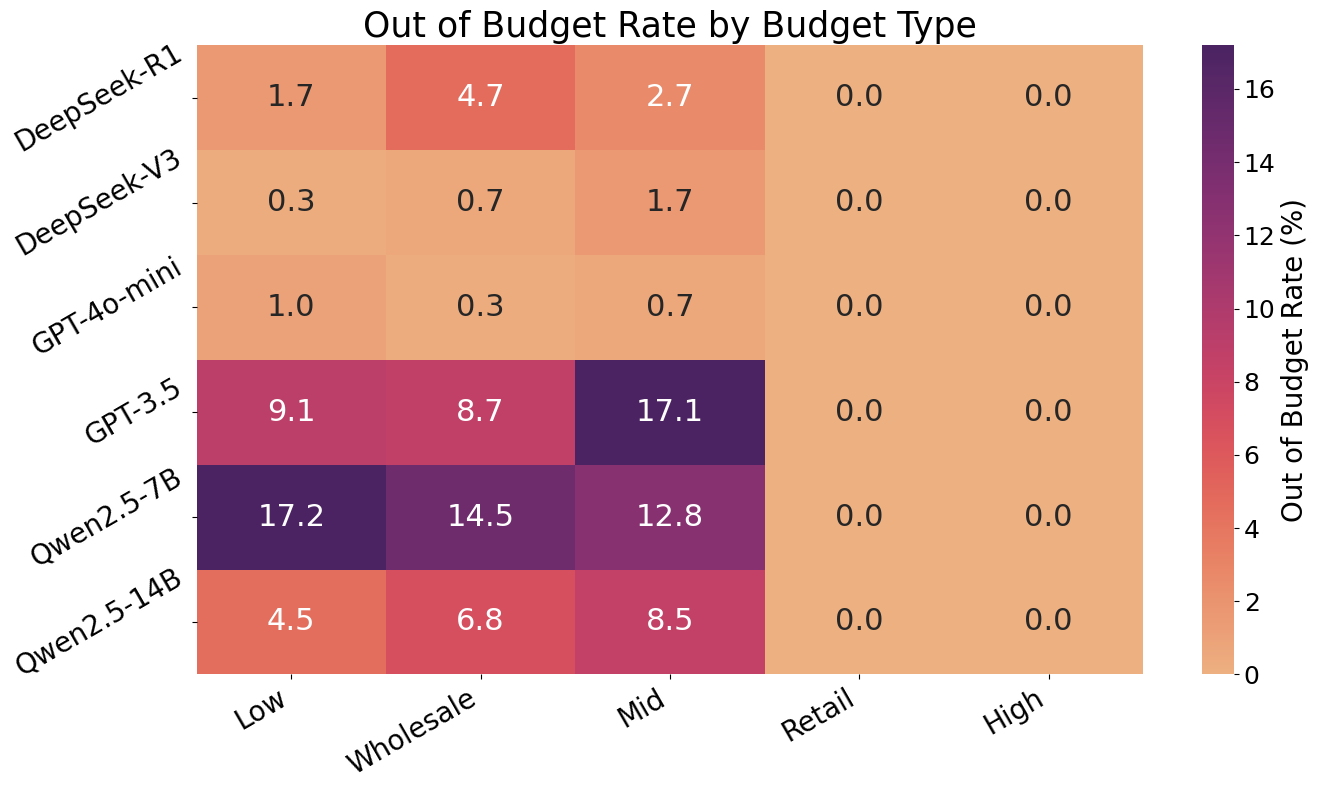

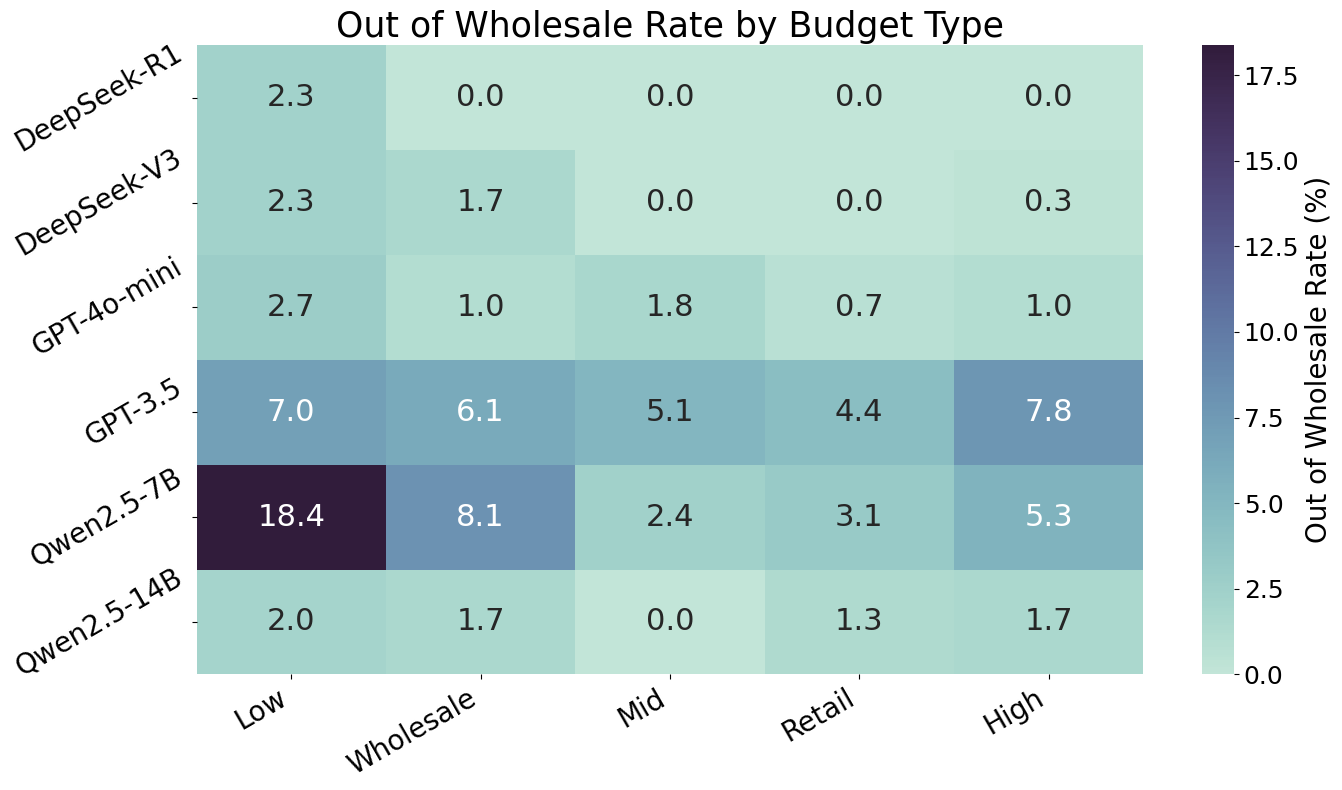

In [4]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def analyze_pricing_violations_by_budget():
    # Directory for analysis
    results_dir = "../results"
    
    # Budget types in specified order
    budget_types = ['low', 'wholesale', 'mid', 'retail', 'high']
    
    # Data structures to track statistics by budget type
    buyer_budget_stats = defaultdict(lambda: defaultdict(lambda: {"total_accepted": 0, "out_of_budget": 0}))
    seller_budget_stats = defaultdict(lambda: defaultdict(lambda: {"total_accepted": 0, "out_of_wholesale": 0}))
    
    # Process the results directory
    for seller_dir in os.listdir(results_dir):
        seller_path = os.path.join(results_dir, seller_dir)
        if not os.path.isdir(seller_path):
            continue
        
        # Extract seller model name
        seller_model = seller_dir.replace("seller_", "")
        
        for buyer_dir in os.listdir(seller_path):
            buyer_path = os.path.join(seller_path, buyer_dir)
            if not os.path.isdir(buyer_path):
                continue
                
            # Extract buyer model name
            buyer_model = buyer_dir
            
            # Traverse through product and budget folders to reach json files
            for root, dirs, files in os.walk(buyer_path):
                for file in files:
                    if file.endswith('.json'):
                        file_path = os.path.join(root, file)
                        
                        try:
                            # Read JSON data
                            with open(file_path, 'r', encoding='utf-8') as f:
                                data = json.load(f)
                            
                            # Override model names if available in JSON data
                            if "models" in data:
                                if "buyer" in data["models"]:
                                    buyer_model = data["models"]["buyer"]
                                if "seller" in data["models"]:
                                    seller_model = data["models"]["seller"]
                            
                            # Get budget type from directory path
                            budget_type = None
                            for budget in budget_types:
                                if f"budget_{budget}" in file_path:
                                    budget_type = budget
                                    break
                            
                            # Skip if we couldn't determine the budget type
                            if not budget_type:
                                continue
                            
                            # Only consider accepted negotiations
                            if data.get("negotiation_result") == "accepted":
                                # Count for buyer statistics (out_of_budget)
                                if "out_of_budget" in data:
                                    buyer_budget_stats[buyer_model][budget_type]["total_accepted"] += 1
                                    
                                    if data["out_of_budget"] == True:
                                        buyer_budget_stats[buyer_model][budget_type]["out_of_budget"] += 1
                                
                                # Count for seller statistics (out_of_wholesale)
                                if "out_of_wholesale" in data:
                                    seller_budget_stats[seller_model][budget_type]["total_accepted"] += 1
                                    
                                    if data["out_of_wholesale"] == True:
                                        seller_budget_stats[seller_model][budget_type]["out_of_wholesale"] += 1
                            else:
                                buyer_budget_stats[buyer_model][budget_type]["total_accepted"] += 1
                                seller_budget_stats[seller_model][budget_type]["total_accepted"] += 1
                        
                        except Exception as e:
                            pass
    
    # Create heatmaps for budget-specific analysis
    create_budget_heatmap(buyer_budget_stats, budget_types, "out_of_budget", "Buyer")
    create_budget_heatmap(seller_budget_stats, budget_types, "out_of_wholesale", "Seller")
    
    return buyer_budget_stats, seller_budget_stats

def create_budget_heatmap(model_budget_stats, budget_types, violation_type, model_type):
    # Rename models for display
    display_names = {
        "deepseek-reasoner": "DeepSeek-R1",
        "deepseek-chat": "DeepSeek-V3",
        "gpt-4o-mini": "GPT-4o-mini",
        "gpt-3.5-turbo": "GPT-3.5",
        "qwen2.5-7b-instruct": "Qwen2.5-7B",
        "qwen2.5-14b-instruct": "Qwen2.5-14B"
    }
    
    # Rename budget types for display
    budget_display = {
        "low": "Low",
        "wholesale": "Wholesale",
        "mid": "Mid",
        "retail": "Retail",
        "high": "High"
    }
    
    # Display titles
    violation_display = {
        "out_of_budget": "Out of Budget Rate",
        "out_of_wholesale": "Out of Wholesale Rate"
    }
    
    # 定义期望的模型顺序
    model_order = [
        "deepseek-reasoner",
        "deepseek-chat",
        "gpt-4o-mini",
        "gpt-3.5-turbo",
        "qwen2.5-7b-instruct",
        "qwen2.5-14b-instruct"
    ]
    
    # 按指定顺序重新排序模型
    models = []
    for model_key in model_order:
        for model in model_budget_stats.keys():
            if model_key.lower() in model.lower():
                models.append(model)
                break
    
    # 创建热图数据
    heatmap_data = []
    
    for model in models:
        row = []
        for budget in budget_types:
            stats = model_budget_stats[model][budget]
            if stats["total_accepted"] > 0:
                rate = stats[violation_type] / stats["total_accepted"] * 100
            else:
                rate = 0
            row.append(rate)
        heatmap_data.append(row)
    
    # Convert to numpy array for heatmap
    heatmap_array = np.array(heatmap_data)
    
    # Create the heatmap
    plt.figure(figsize=(14, 8))
    
    # Choose color map based on violation type
    cmap = "flare" if violation_type == "out_of_budget" else sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
    
    # Create heatmap with annotation
    ax = sns.heatmap(
        heatmap_array,
        cmap=cmap,
        annot=True,                   
        fmt=".1f",                     
        annot_kws={"fontsize": 22},  
        yticklabels=[display_names.get(m, m) for m in models],
        xticklabels=[budget_display[b] for b in budget_types],
        vmin=0
    )

    
    # Add colorbar label
    cbar = ax.collections[0].colorbar
    cbar.set_label(f'{violation_display[violation_type]} (%)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    
    # Set labels and title
    plt.title(f'{violation_display[violation_type]} by Budget Type', fontsize=25)
    
    # Adjust rotation for better readability
    plt.xticks(rotation=30, ha='right', fontsize=20)
    plt.yticks(fontsize=20, rotation=30)
    
    # Adjust layout and save
    plt.tight_layout()
    output_dir = "../figures"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"{violation_type}_by_budget.svg"), dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

if __name__ == "__main__":
    analyze_pricing_violations_by_budget()